In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from mlflux.eval import evaluate, eval_bias, plot_pred, plot_res, plot_corr

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

In [ ]:
datafile = '/scratch/jw8736/mlflux/data/Processed/psd_coare3p6_weight1_wave0.nc'
ds_psd = xr.load_dataset(datafile)

In [8]:
from mlflux.datafunc import data_split_psd_rand
# Training and testing split
training_ds, validating_ds, testing_ds = data_split_psd_rand(ds_psd, seed=4, ratio=0.2)

# Regional split
splits = [[77], [67, 72, 78], [73, 71], [68, 83, 69, 87]]
ds_sets = [ds_psd.where(ds_psd.pcode.isin(split), drop=True) for split in splits]

In [9]:
### Load ANN
from mlflux.eval import open_case
LH_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SH_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
M_dir  = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
M_cross_dir  = f'/scratch/jw8736/mlflux/saved_model/final/Mcross5_1/NW_tr2/'
rand_seed = 4 # choose the one random seed where loss curves look good

model_M = open_case (M_dir, 'model_rand%g.p' %rand_seed)
model_M_cross = open_case (M_cross_dir, 'model_rand%g.p' %rand_seed)
model_SH = open_case (SH_dir, 'model_rand%g.p' %rand_seed)
model_LH = open_case (LH_dir, 'model_rand%g.p' %rand_seed)

In [10]:
from compute_flux_coeff import add_field, compute_coeff

testing_ds = add_field (testing_ds, model_M, model_M_cross, model_SH, model_LH)
training_ds = add_field (training_ds, model_M, model_M_cross, model_SH, model_LH)

testing_ds = compute_coeff(testing_ds)
training_ds = compute_coeff(training_ds)

ds_psd = add_field (ds_psd, model_M, model_M_cross, model_SH, model_LH)
ds_psd = compute_coeff(ds_psd)

# Regional split
splits = [[77], [67, 72, 78], [73, 71], [68, 83, 69, 87]]
ds_sets = [ds_psd.where(ds_psd.pcode.isin(split), drop=True) for split in splits]

for ds in ds_sets:
    # ds['rh'] = 80 * ds['U']/ds['U']
    ds = add_field(ds, model_M, model_M_cross, model_SH, model_LH)
    ds = compute_coeff(ds)

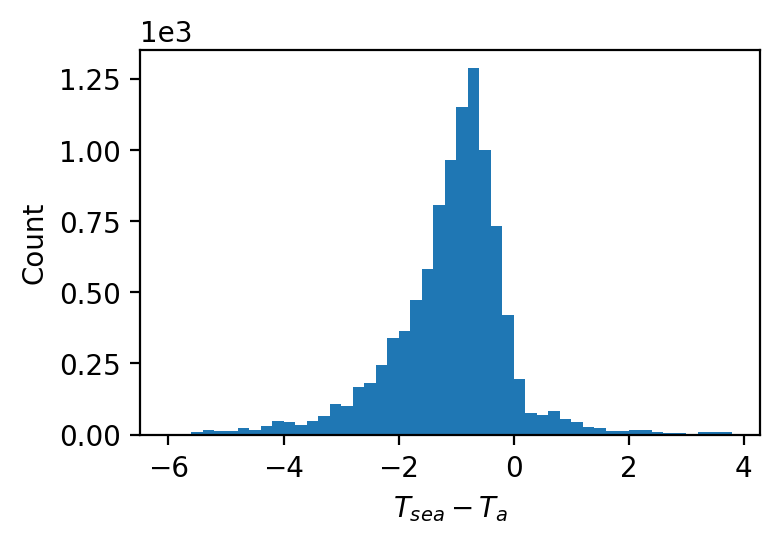

In [6]:
### Query certain distributions
ds = ds_psd

# Non-dimensional height
# fig = plt.figure(figsize=[4,2.5], dpi=200); ax = plt.gca()
# Phi = ds.zu/ds.MOL
# Phi.plot.hist(bins=np.arange(-4,2,0.25))
# plt.xlabel('$\zeta = z_u/L$'); plt.ylabel('Count'); 
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.ylim([0, 4000]); plt.xlim([-4,2])

# fig = plt.figure(figsize=[4,2.5], dpi=200); ax = plt.gca()
# dq = ds.qsea - ds.qair 
# dq.plot.hist(bins=20)
# plt.xlabel('$q_{sea} - q_{a}$'); plt.ylabel('Count'); 
# ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig = plt.figure(figsize=[4,2.5], dpi=200); ax = plt.gca()
dT = ds.tair - ds.tsea
dT.plot.hist(bins=np.arange(-6,4,0.2))
plt.xlabel('$T_{sea} - T_{a}$'); plt.ylabel('Count'); 
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

In [11]:
import matplotlib as mpl
def add_cbar (fig, vmin, vmax, cbar_loc, cbar_label, cmap_name, orientation):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # Set vmin/vmax to match the range of `i`
    sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=norm) # Create a ScalarMappable for the colorbar
    sm.set_array([])  # Required to set an array for ScalarMappable
    cbar_ax = fig.add_axes(cbar_loc)  
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation=orientation)
    cbar.set_label(cbar_label, labelpad=-5)

### All coefficients together

/tmp/ipykernel_99949/1422575276.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


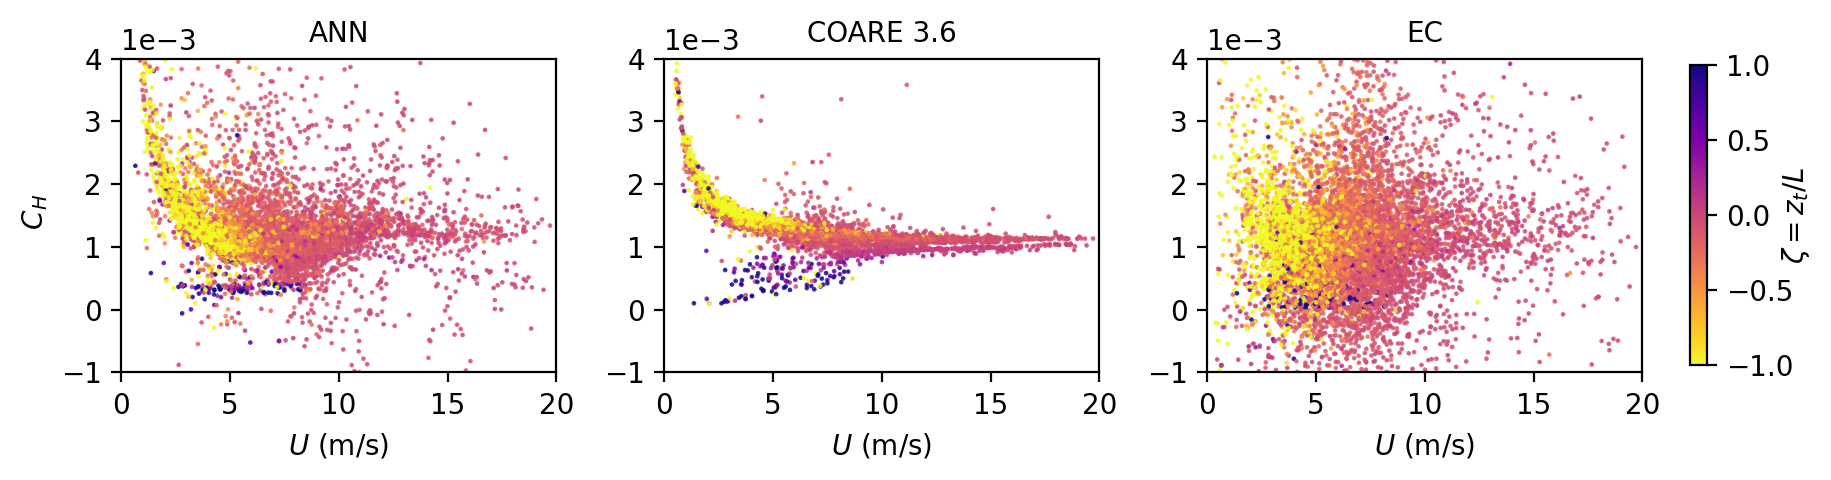

In [12]:
### For all data together 
fig, axes = plt.subplots(1, 3, figsize=[8.5,2.5], dpi=200)
imgs = []
mappable = None
cmap = 'plasma_r'
COEFF = 'CT'  # 'CT' or 'CE' or 'CD'

ds_ = ds_psd

if COEFF == 'CD':
    img1 = axes[0].scatter(ds_['U'], ds_['ann_CD'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[1].scatter(ds_['U'], ds_['bulk_CD'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[2].scatter(ds_['U'], ds_['CD'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
elif COEFF == 'CT':
    ds_ = ds_.where(abs(ds_.tsea - ds_.tair) > 0.2, drop=True) # These filtering nees to be adjusted
    img1 = axes[0].scatter(ds_['U'], ds_['ann_CT'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[1].scatter(ds_['U'], ds_['bulk_CT'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[2].scatter(ds_['U'], ds_['CT'], c=ds_['zt']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
elif COEFF == 'CE':
    ds_ = ds_.where(abs(ds_.qsea - ds_.qair) > 0.001, drop=True) # These filtering nees to be adjusted
    img1 = axes[0].scatter(ds_['U'], ds_['ann_CE'], c=ds_['zq']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[1].scatter(ds_['U'], ds_['bulk_CE'], c=ds_['zq']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[2].scatter(ds_['U'], ds_['CE'], c=ds_['zq']/ds_['MOL'], 
                                marker='o', cmap=cmap, s=0.5, alpha=0.8, vmax=1, vmin=-1)
    
if mappable is None:
    mappable = img1

cbar_label = '$\zeta = z_u / L$' if COEFF == 'CD' else ('$\zeta = z_t / L$' if COEFF == 'CT' else '$\zeta = z_q / L$')
ylabel = f'$C_D$' if COEFF == 'CD' else (' $C_H$' if COEFF == 'CT' else '$C_E$')
add_cbar (fig, vmin=-1, vmax=1, cbar_loc=[1,0.25,0.01,0.6], 
          cbar_label=cbar_label, cmap_name=cmap, orientation='vertical')
algs = ['ANN', 'COARE 3.6', 'EC']
axes[0].set_ylabel(ylabel)

# common axis limits
for i, ax in enumerate(axes):
    ax.set_ylim([-0.001,0.004])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlim([0,20])
    ax.set_xlabel(r'$U$ (m/s)')
    ax.set_title(algs[i], fontsize=10)   

plt.tight_layout()
filename = f'CD_all.pdf' if COEFF == 'CD' else (f'CT_all.pdf' if COEFF == 'CT' else f'CE_all_dt_over_05.pdf')
plt.savefig(filename, bbox_inches='tight')

### Region by region

/tmp/ipykernel_99949/3310942524.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


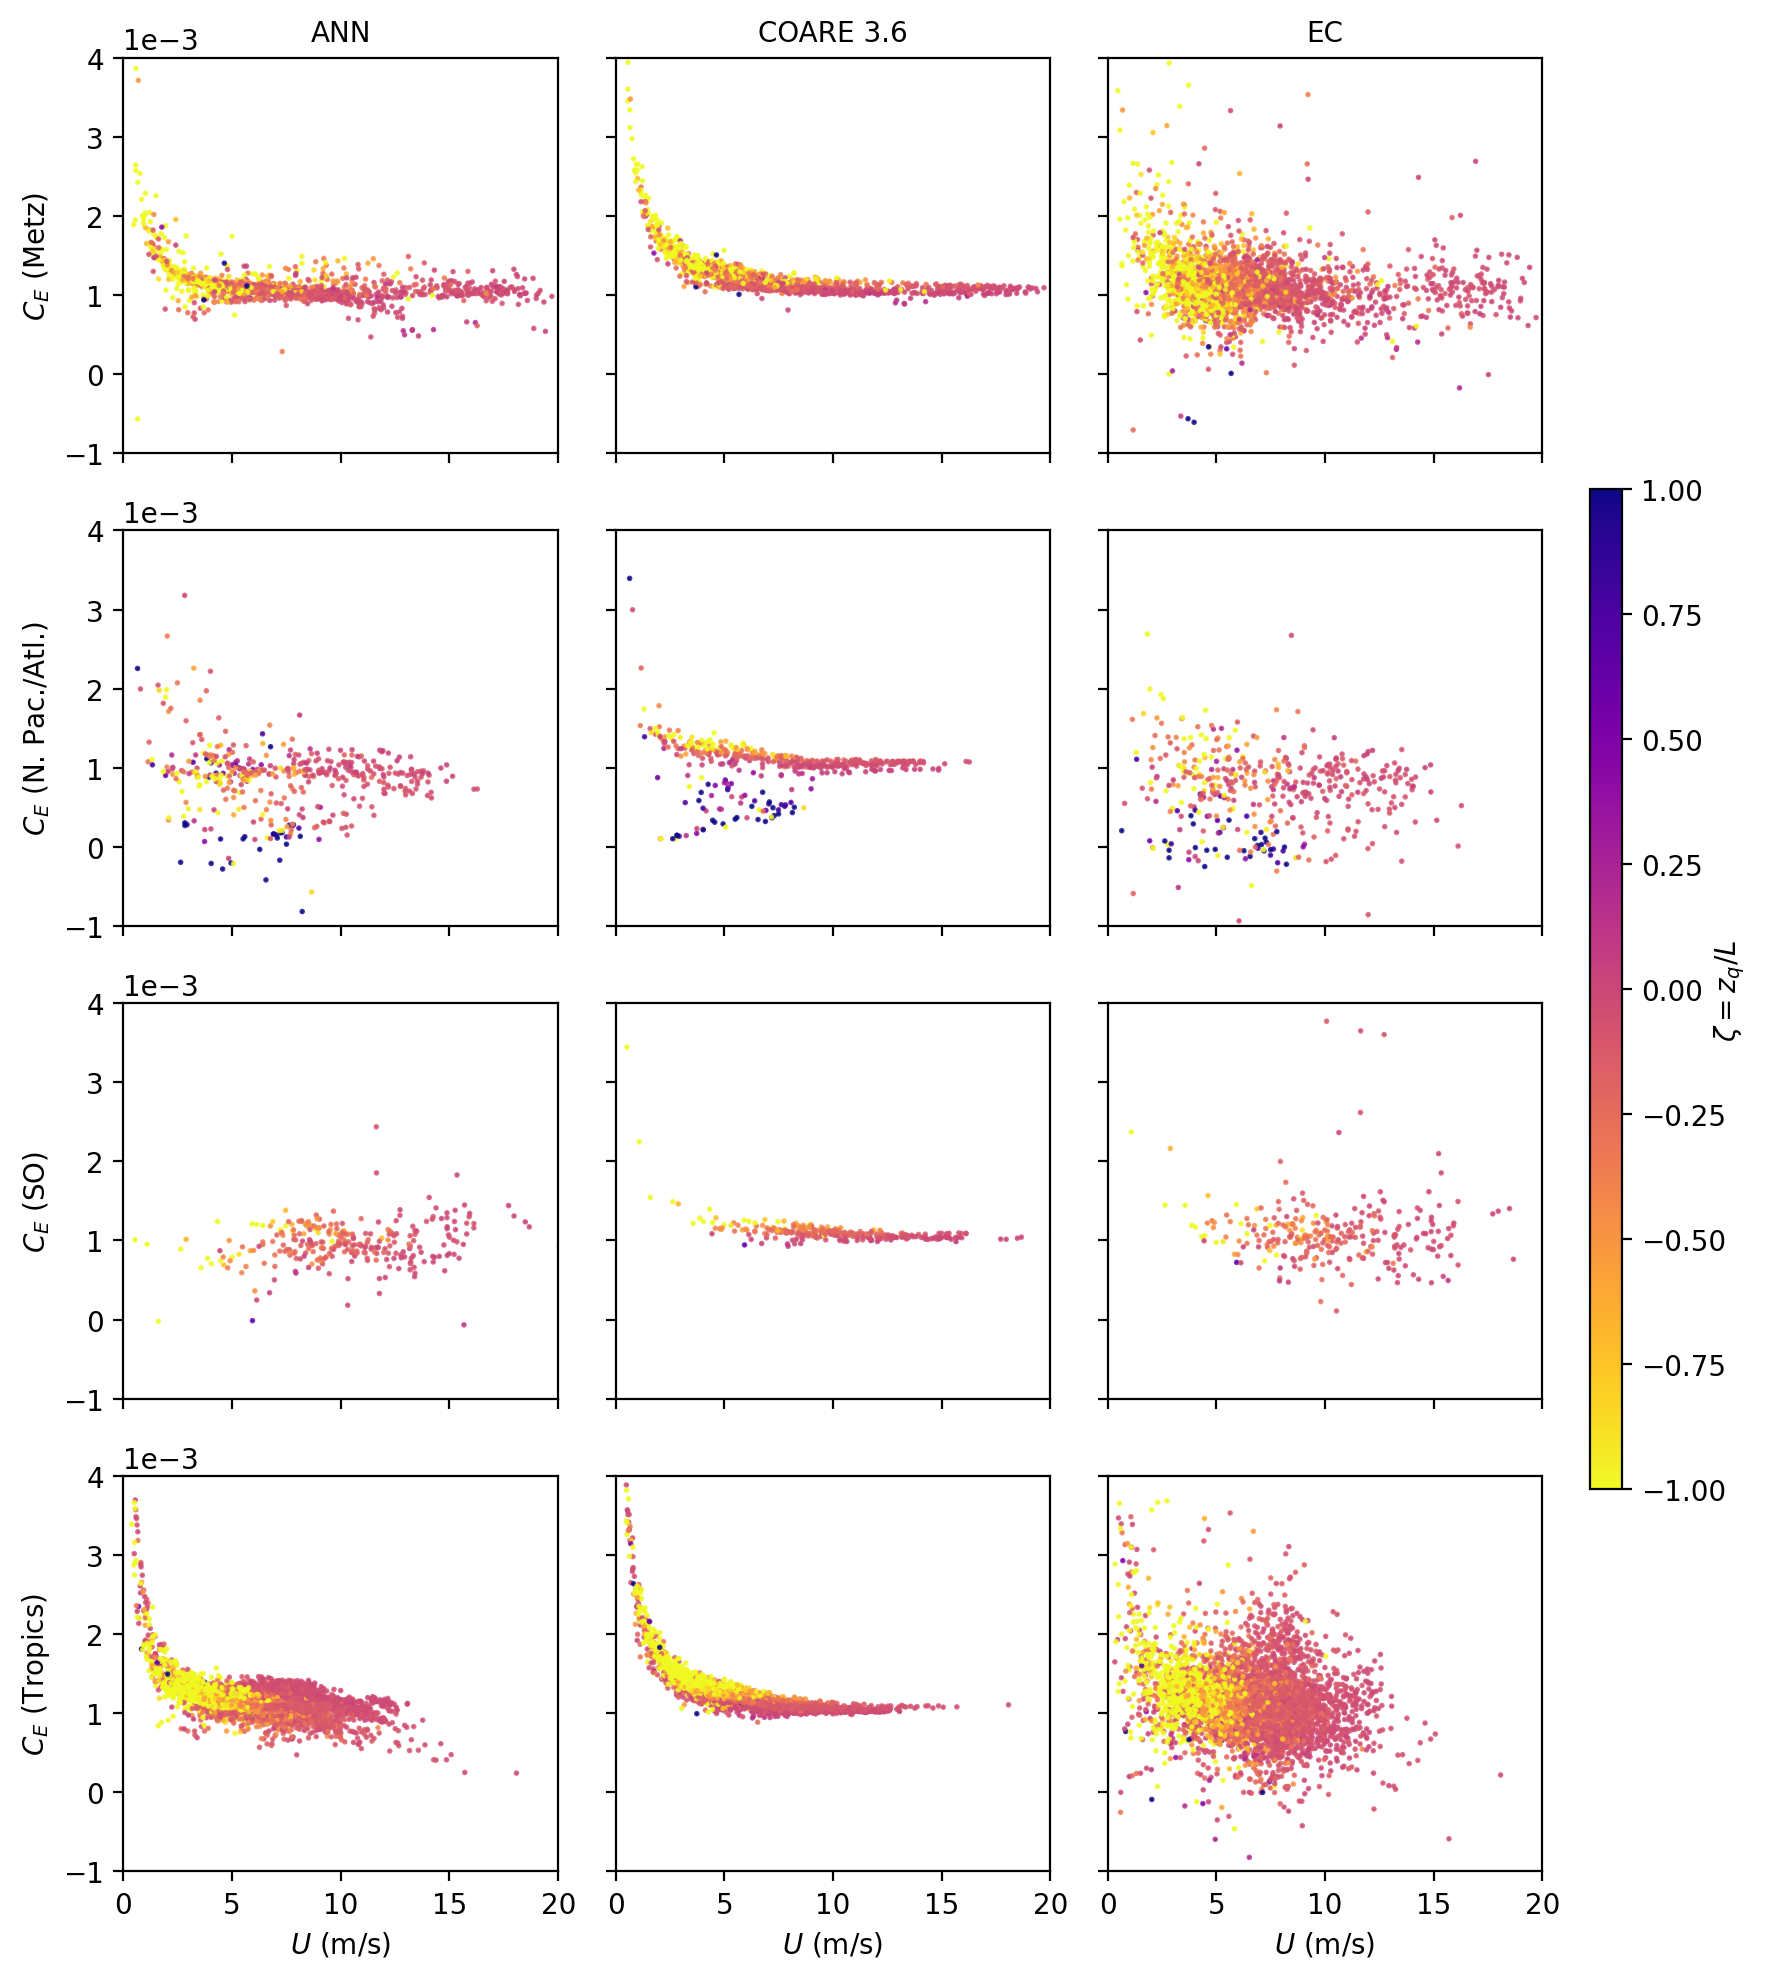

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axes = plt.subplots(4, 3, figsize=[8, 10], sharex=True, sharey=True, dpi=200)
imgs = []
mappable = None
cmap = 'plasma_r'

for i in range(0,4):
    ds_ = ds_sets[i]
    # ds_ = ds_.where(abs(ds_.tsea - ds_.tair) > 0.5, drop=True)
    ds_ = ds_.where(abs(ds_.qsea - ds_.qair) > 0.001, drop=True)
    img1 = axes[i,0].scatter(ds_['U'], ds_['ann_CE'], c=ds_['zq']/ds_['MOL'], 
                             marker='o', cmap=cmap, s=1, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[i,1].scatter(ds_['U'], ds_['bulk_CE'], c=ds_['zq']/ds_['MOL'], 
                             marker='o', cmap=cmap, s=1, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[i,2].scatter(ds_['U'], ds_['CE'], c=ds_['zq']/ds_['MOL'], 
                             marker='o', cmap=cmap, s=1, alpha=0.8, vmax=1, vmin=-1)
    # imgs.append(img1); imgs.append(img2); imgs.append(img3)
    if mappable is None:
        mappable = img1

add_cbar (fig, vmin=-1, vmax=1, cbar_loc=[1,0.25,0.02,0.5], 
          cbar_label=r'$\zeta = z_q/L$ ', cmap_name=cmap, orientation='vertical')
    
regions = ['Metz', 'N. Pac./Atl.', 'SO', 'Tropics']
algs = ['ANN', 'COARE 3.6', 'EC']
# common axis limits
for i, row in enumerate(axes):
    row[0].set_ylabel(f'$C_E$ ({regions[i]})')
    # row[0].text(-0.3, 0.5, regions[i], va='center', ha='center', rotation='vertical', 
    #             transform=row[0].transAxes, fontsize=10)
    for j, ax in enumerate(row):
        ax.set_ylim([-0.001,0.004])
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_xlim([0,20])
        if i == 3:
            ax.set_xlabel(r'$U$ (m/s)')
        if i == 0:
            ax.set_title(algs[j], fontsize=10)   

plt.tight_layout()
plt.show()
plt.savefig('CE_regions.pdf', bbox_inches='tight')

### Look at latent heat flux for specific regions where the skill improvement is the largest

Bulk on the whole data set mse=[554.3897786], r2=[0.46003441]
NN on the whole data set mse=[337.59401692], r2=[0.67118955]
Bulk on abs error < 50 subset mse=[251.42344212], r2=[0.75089821]
NN on abs error < 50 subset mse=[207.36423458], r2=[0.79455057]


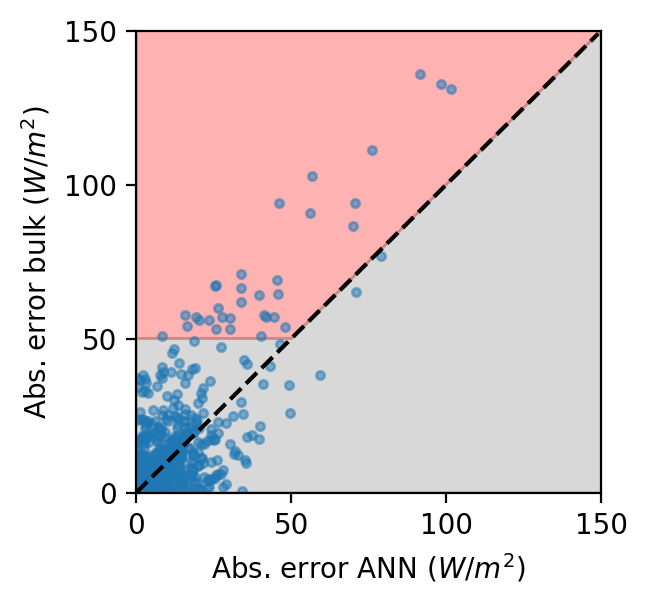

In [16]:

fig = plt.figure(figsize=[3,3], dpi=200)

i = 1
ds = ds_sets[i]
if i == 1: # NPA
    filename = 'CE_NPA_scatter.png'
elif i == 3: #Tropics
    filename = 'CE_tropics_scatter.png'

ds_ = ds.where(abs(ds.qsea - ds.qair) > 0.001, drop=True)
plt.plot(abs(ds_.LH - ds_.hlc), abs(ds_.hlb - ds_.hlc), '.', alpha=0.5)
plt.xlabel('Abs. error ANN ($W/m^2$)'); plt.ylabel('Abs. error bulk ($W/m^2$)')
if i == 1: # NPA
    plt.plot(np.arange(0,150), np.arange(0,150), '--', c='k')
    plt.xlim([0,150]); plt.ylim([0,150]); plt.yticks([0,50,100,150])
elif i == 3: #Tropics
    plt.plot(np.arange(0,200), np.arange(0,200), '--', c='k')
    plt.xlim([0,200]); plt.ylim([0,200]); plt.yticks([0,50,100,150,200])

# plt.plot(np.arange(0,50), np.ones(50)*50, '--', c='b')
# plt.plot(np.ones(50)*50, np.arange(0,50), '--', c='b')

# Define the trapsoid vertices
if i == 1: # NPA
    x_poly = [0, 0, 150, 50]
    y_poly = [50, 150, 150, 50]
    plt.fill(x_poly, y_poly, color='red', alpha=0.3, label='Large errors')
    x_poly = [0, 0, 50, 150, 150]
    y_poly = [0, 50, 50, 150, 0]
    plt.fill(x_poly, y_poly, color='gray', alpha=0.3)
    
if i == 3: # NPA
    x_poly = [0, 0, 200, 50]
    y_poly = [50, 200, 200, 50]
    plt.fill(x_poly, y_poly, color='red', alpha=0.3)
    x_poly = [0, 0, 50, 200, 200]
    y_poly = [0, 50, 50, 200, 0]
    plt.fill(x_poly, y_poly, color='gray', alpha=0.3)

plt.savefig(filename, bbox_inches='tight')

ds_sub = ds.where(abs(ds.hlb - ds.hlc) < 50, drop=True)
from mlflux.eval import mse_r2
mse, r2 = mse_r2(ds.hlb, ds.hlc)
print(f'Bulk on the whole data set mse={mse}, r2={r2}')
mse, r2 = mse_r2(ds.LH, ds.hlc)
print(f'NN on the whole data set mse={mse}, r2={r2}')
mse, r2 = mse_r2(ds_sub.hlb, ds_sub.hlc)
print(f'Bulk on abs error < 50 subset mse={mse}, r2={r2}')
mse, r2 = mse_r2(ds_sub.LH, ds_sub.hlc)
print(f'NN on abs error < 50 subset mse={mse}, r2={r2}')

/tmp/ipykernel_71802/1850662677.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  img1 = axes[0].scatter(ds_['U'], ds_['ann_CE'], c='gray',
/tmp/ipykernel_71802/1850662677.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  img2 = axes[1].scatter(ds_['U'], ds_['bulk_CE'], c='gray',
/tmp/ipykernel_71802/1850662677.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  img3 = axes[2].scatter(ds_['U'], ds_['CE'], c='gray',
/tmp/ipykernel_71802/1850662677.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  img1 = axes[0].scatter(ds_['U'], ds_['ann_CE'], c='r',
/tmp/ipykernel_71802/1850662677.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  img2 = axes[1].scatter(ds_['U'], ds_['bulk_CE'], c='r',
/tmp/ipykernel_71802/18

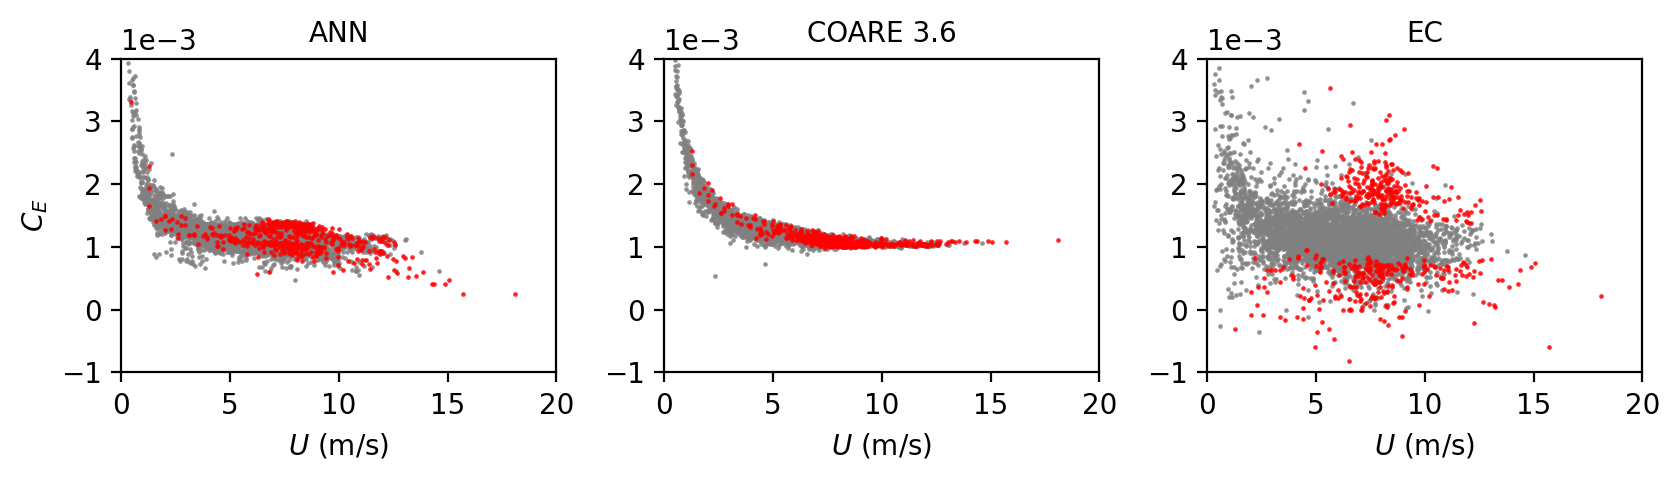

In [ ]:
### For all data together 
fig, axes = plt.subplots(1, 3, figsize=[8.5,2.5], dpi=200)
imgs = []
mappable = None
cmap = 'plasma_r'
COEFF = 'CE'  # 'CT' or 'CE' or 'CD'

i = 3
ds = ds_sets[i]
if i == 1: # NPA
    filename = 'CE_NPA.png' 
elif i == 3: #Tropics
    filename = 'CE_tropics.png'

# The other fluxes not yet plotted
if COEFF == 'CE':
    ds = ds.where(abs(ds.qsea - ds.qair) > 0.001, drop=True)
    # Pick really large errors
    # Can also pick poorer performance of bulk
    ds_ = ds.where(
        (abs(ds.hlb - ds.hlc) < 50) | 
        ((abs(ds.hlb - ds.hlc) - abs(ds.LH - ds.hlc)) < 0),
        drop=True
    )
    img1 = axes[0].scatter(ds_['U'], ds_['ann_CE'], c='gray', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[1].scatter(ds_['U'], ds_['bulk_CE'], c='gray', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[2].scatter(ds_['U'], ds_['CE'], c='gray', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1)   
    ds_ = ds.where(
        (abs(ds.hlb - ds.hlc) > 50) &
        ((abs(ds.hlb - ds.hlc) - abs(ds.LH - ds.hlc)) > 0),
        drop=True
    )
    img1 = axes[0].scatter(ds_['U'], ds_['ann_CE'], c='r', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img2 = axes[1].scatter(ds_['U'], ds_['bulk_CE'], c='r', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1)
    img3 = axes[2].scatter(ds_['U'], ds_['CE'], c='r', 
                                marker='o', s=0.5, alpha=0.8, vmax=1, vmin=-1) 

algs = ['ANN', 'COARE 3.6', 'EC']
axes[0].set_ylabel(ylabel)

# common axis limits
for i, ax in enumerate(axes):
    ax.set_ylim([-0.001,0.004])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlim([0,20])
    ax.set_xlabel(r'$U$ (m/s)')
    ax.set_title(algs[i], fontsize=10)   

plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[4,1.5], dpi=200)
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
ds_sub['zeta'] = ds_sub.zt/ds_sub.MOL
axes[0].scatter(ds_sub.zeta, ds_sub.hsc, 
                s=1, c=ds_sub.ann_CE-ds_sub.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
axes[1].scatter(ds_sub.hlc, ds_sub.hsc, 
                s=1, c=ds_sub.ann_CE-ds_sub.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
plt.tight_layout()

### Check sensitivity around the mean value

In [ ]:
### Sensitivity test

ds = ds_sets[1]
vd = RealFluxDataset(ds, input_keys=model_M.config['ikeys'], 
                     output_keys=model_M.config['okeys'], bulk_keys=model_M.config['bkeys'])
X_mean = vd.X.mean(axis=0)
X_std = vd.X.std(axis=0)
M,SH,LH,CD,CT,CE = compute(X_mean, label='COARE3p6')
print(M,SH,LH,CD,CT,CE)
M,SH,LH,CD,CT,CE = compute(X_mean, label='ANN')
print(M,SH,LH,CD,CT,CE)

ds = ds_sets[1]
vd = RealFluxDataset(ds, input_keys=model_M.config['ikeys'], 
                     output_keys=model_M.config['okeys'], bulk_keys=model_M.config['bkeys'])
X_mean = vd.X.mean(axis=0)
X_std = vd.X.std(axis=0)

print(X_mean)
print(X_std)

M_mean,SH_mean,LH_mean,CD_mean,CT_mean,CE_mean = compute(X_mean)
print('Mean CE ' + f'{CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([X_std[0],0,0,0,0]))
print('CE plus 1 delta wind speed ' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([-X_std[0],0,0,0,0]))
print('CE minus 1 delta wind speed' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,X_std[1],0,0,0]))
print('CE plus 1 delta tsea' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,-X_std[1],0,0,0]))
print('CE minus 1 delta tsea' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,X_std[2],0,0]))
print('CE plus 1 delta tair' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,-X_std[2],0,0]))
print('CE minus 1 delta tair' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,0,X_std[3],0]))
print('CE plus 1 delta RH' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,0,-X_std[3],0]))
print('CE minus 1 delta RH' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,0,0,X_std[4]]))
print('CE plus 1 delta pressure' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

M,SH,LH,CD,CT,CE = compute(X_mean + torch.tensor([0,0,0,0,-X_std[4]]))
print('CE minus 1 delta pressure' + f'{CE}')
print('Relative change' + f'{(CE-CE_mean)/CE_mean}')

0.08022654500812305 -1.095727572311374 38.07805407485355 0.0011136870537020007 0.00110960179417687 0.00110960179417687
0.06812587 3.4828157 -35.40577 0.0009467082 0.0035174023 0.0010265608


In [ ]:
from mlflux.COARE.COARE3p5 import coare35vn

size = len(ds_psd.U.values)
ds = ds_psd
p = ds.p.values/100.
A3p5 = coare35vn(u=ds.U.values, t=ds.tair.values, rh=ds.rh.values, ts=ds.tsea.values, 
                 P=p, Rs=150, Rl=370, zu=16, zt=16, zq=16, lat=ds.lat.values, zi=np.ones(size)*600, 
                 rain=np.zeros(size), jcool=0)
A3p5_buoy = coare35vn(u=ds.U.values, t=ds.tair.values, rh=ds.rh.values, ts=ds.tsea.values, 
                 P=p, Rs=150, Rl=370, zu=5, zt=5, zq=5, lat=ds.lat.values, zi=np.ones(size)*600, 
                 rain=np.zeros(size), jcool=0)

# list1 = [usr,tau,hsb,hlb,hbb,hsbb,hlwebb,tsr,qsr,zot,zoq,Cd,Ch,Ce,L,zet]
# list1 = [0,  1,  2,  3,  4,  5,   6,     7,  8,  9,  10, 11,12,13,14,15]
# list2 = [dter,dqer,tkt,Urf,Trf,Qrf,RHrf,UrfN,Rnl,Le,rhoa,Qs,Q, dq, ut, gf, dt, UN,U10,U10N]
# list2 = [16,  17,  18, 19, 20, 21, 22,  23,  24, 25,26,  27,28,29, 30, 31, 32, 33, 34, 35]
# list3 = [Cdn_10,Chn_10,Cen_10,RF,Evap,Qs,Q10,RH10]
# out = tuple(list1 + list2 + list3)

# [usr,tau,hsb,hlb,hlwebb,tsr,qsr,zot,zoq,Cd,Ch,Ce,L,zet]
# [dter,dqer,tkt,RF,Cdn_10,Chn_10,Cen_10]

from mlflux.COARE.COARE3p6 import coare36vn_zrf_et 

A3p6, aux_fields = coare36vn_zrf_et(u=ds.U.values, zu=ds.zu.values, t=ds.tair.values, zt=ds.zt.values, 
                     rh=ds.rh.values, zq=ds.zq.values, P=ds.p.values/100, ts=ds.tsea.values, 
                     sw_dn=np.zeros(size), lw_dn=np.ones(size)*400, lat=ds.lat.values, lon=ds.lon.values, 
                     jd=np.ones(size)*10, zi=np.ones(size)*600, rain=np.zeros(size), Ss=np.ones(size)*35, 
                     cp=None, sigH=None, zrf_u=10.0, zrf_t=10.0, zrf_q=10.0)  

# out = np.array([usr,tau,hsb,hlb,hbb,hsbb,hlwebb,tsr,qsr,zo,zot,zoq,
# out = np.array([0 , 1,  2,  3,  4,  5,   6,     7,  8,  9, 10, 11,
# Cd,Ch,Ce,L,zeta,dT_skinx,dq_skinx,dz_skin,Urf,Trf,Qrf,RHrf,UrfN,TrfN,QrfN,lw_net,sw_net,Le,rhoa,
# 11,12,13,14,15,16,       17,      18,     19, 20, 21, 22,  23,  24,  25,  26,    27,    28,29
# UN,U10,U10N,Cdn_10,Chn_10,Cen_10,hrain,Qs,Evap,T10,T10N,Q10,Q10N,RH10,P10,rhoa10,gust,wc_frac,Edis]) 
# 30,31, 32,  33,    34,    35,    36,   37,38,  39, 40,  41, 42,  43,  44, 45,    46,  47,     48

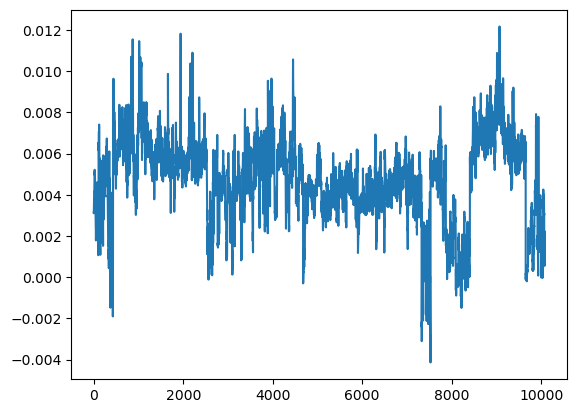

In [145]:
plt.plot(ds_psd.qsea - ds_psd.qair)

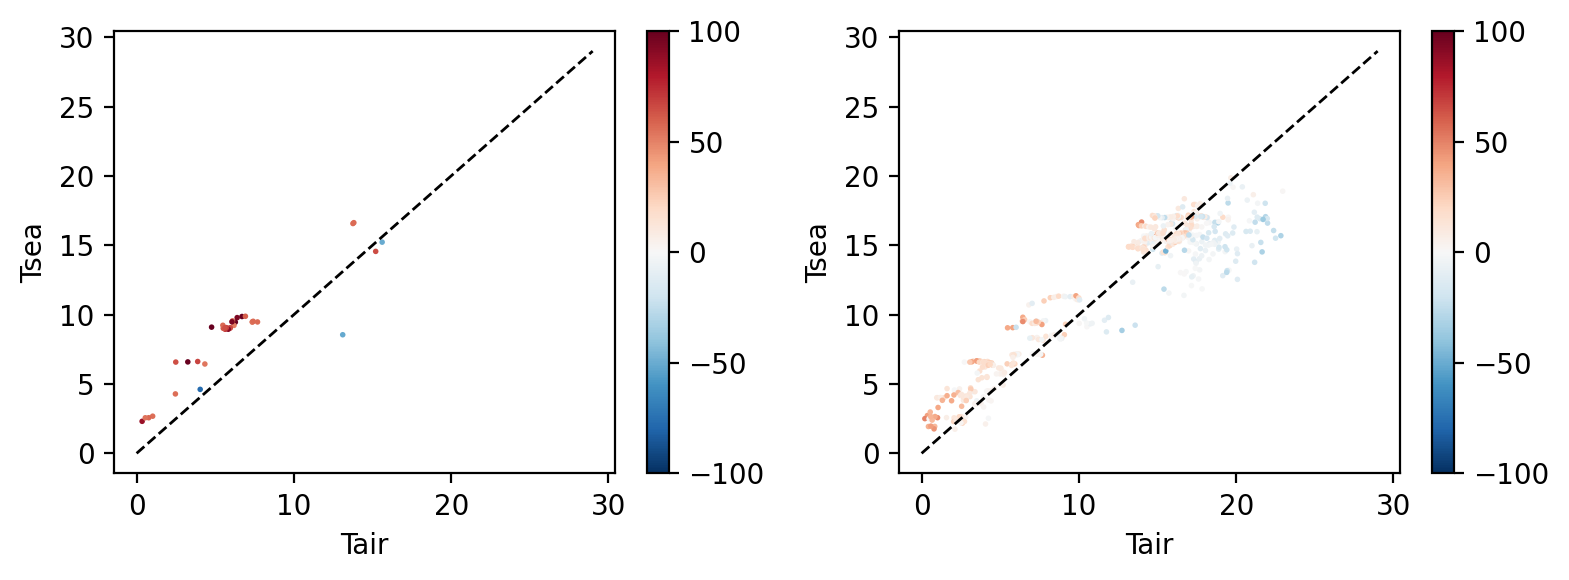

In [83]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)
ds_ = ds_sets[1]

axes[0].plot(np.arange(0,30), np.arange(0,30), '--', c='k', lw=1)
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
img1 = axes[0].scatter(ds_sub.tair, ds_sub.tsea, 
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair')
axes[0].set_ylabel('Tsea')

axes[1].plot(np.arange(0,30), np.arange(0,30), '--', c='k', lw=1)
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.tair, ds_sub.tsea, 
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair')
axes[1].set_ylabel('Tsea')
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

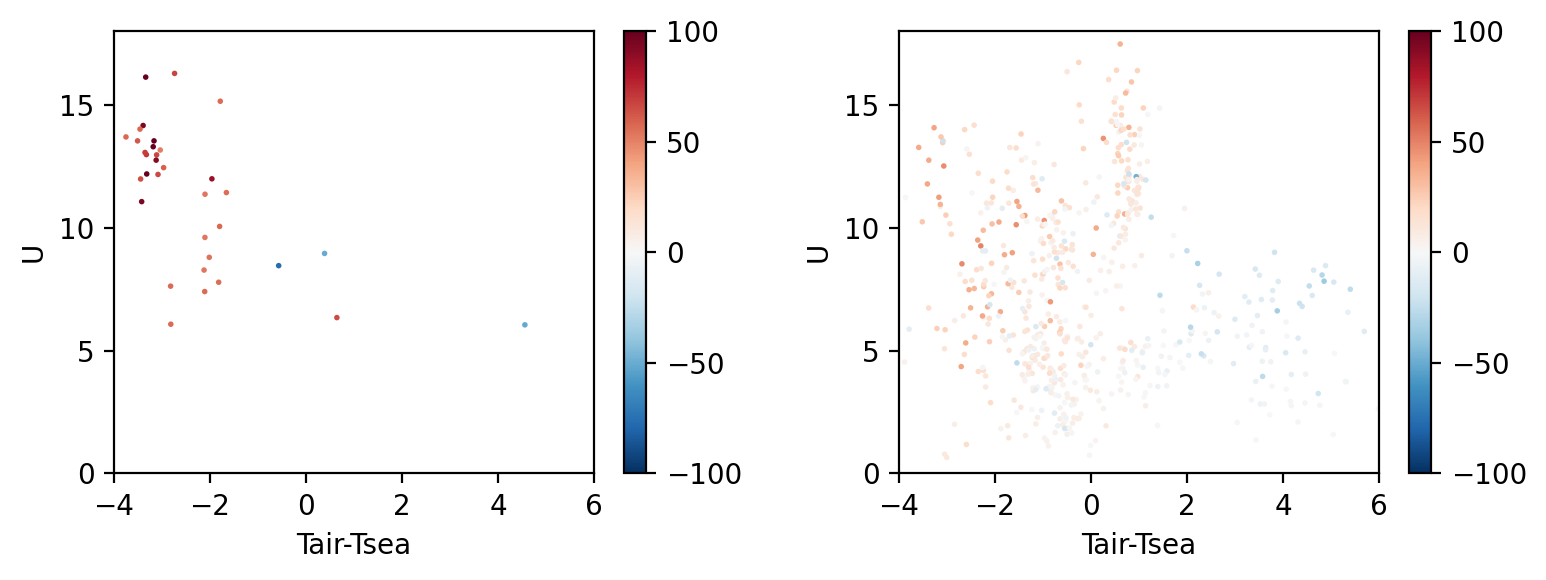

In [105]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)
ds_ = ds_sets[1]

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
img1 = axes[0].scatter(ds_sub.tair - ds_sub.tsea, ds_sub.U,
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair-Tsea')
axes[0].set_ylabel('U')

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.tair - ds_sub.tsea, ds_sub.U,
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair-Tsea')
axes[1].set_ylabel('U')

axes[0].set_ylim([0,18]); axes[0].set_xlim([-4,6])
axes[1].set_ylim([0,18]); axes[1].set_xlim([-4,6])
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

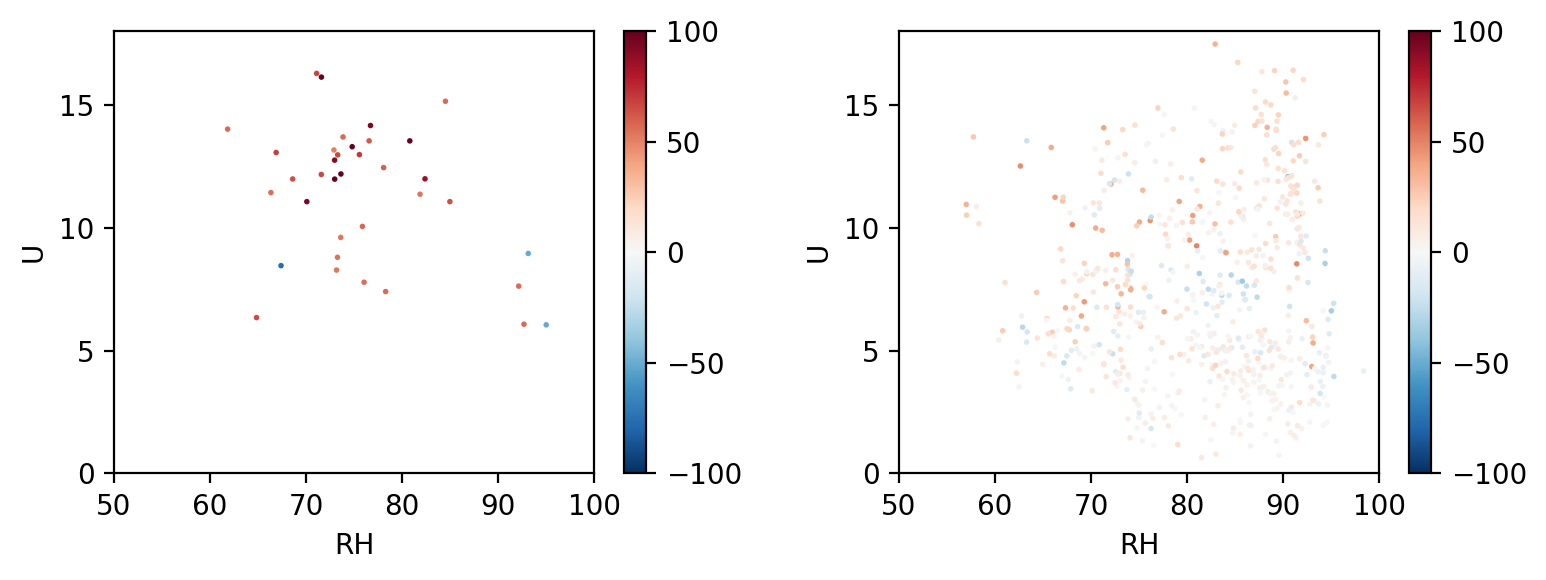

In [111]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)
ds_ = ds_sets[1]

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
img1 = axes[0].scatter(ds_sub.rh, ds_sub.U,
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('RH')
axes[0].set_ylabel('U')

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.rh, ds_sub.U,
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('RH')
axes[1].set_ylabel('U')

axes[0].set_xlim([50,100]); axes[0].set_ylim([0,18])
axes[1].set_xlim([50,100]); axes[1].set_ylim([0,18])
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

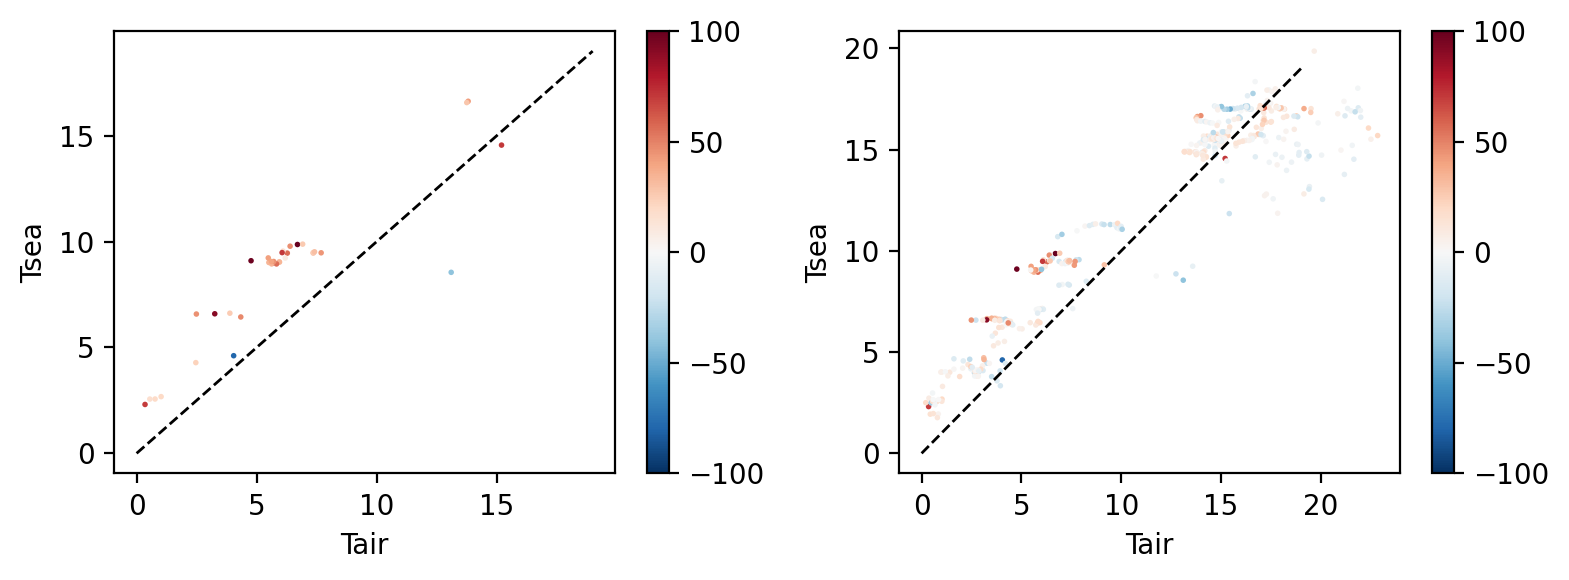

In [57]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
axes[0].plot(np.arange(0,20), np.arange(0,20), '--', c='k', lw=1)
img1 = axes[0].scatter(ds_sub.tair, ds_sub.tsea, 
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair')
axes[0].set_ylabel('Tsea')
axes[1].plot(np.arange(0,20), np.arange(0,20), '--', c='k', lw=1)
img2 = axes[1].scatter(ds_.tair, ds_.tsea, 
                s=4, c=-ds_.LH+ds_.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair')
axes[1].set_ylabel('Tsea')
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

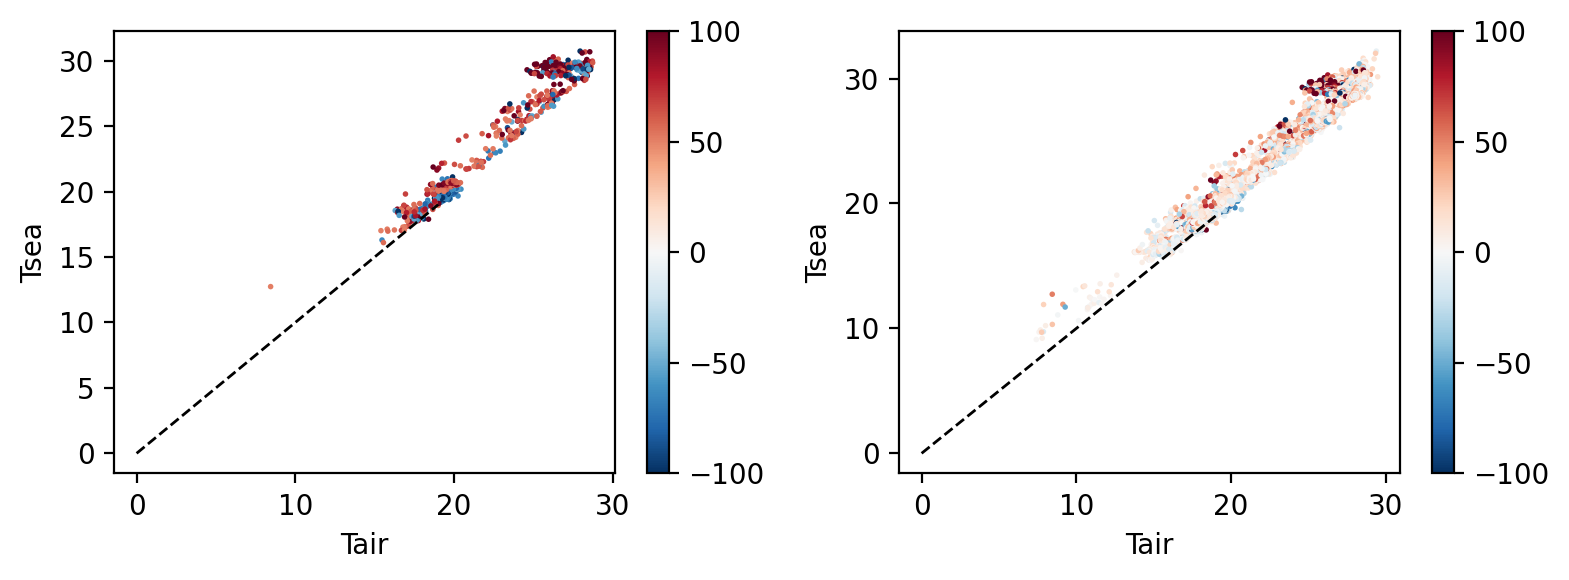

In [67]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)

ds_sub = ds_sets[3].where(abs(ds_sets[3].hlb - ds_sets[3].hlc) > 50, drop=True)
axes[0].plot(np.arange(0,20), np.arange(0,20), '--', c='k', lw=1)
img1 = axes[0].scatter(ds_sub.tair, ds_sub.tsea, 
                s=4, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair')
axes[0].set_ylabel('Tsea')
axes[1].plot(np.arange(0,20), np.arange(0,20), '--', c='k', lw=1)
img2 = axes[1].scatter(ds_sets[3].tair, ds_sets[3].tsea, 
                s=4, c=-ds_sets[3].hlb+ds_sets[3].hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair')
axes[1].set_ylabel('Tsea')
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

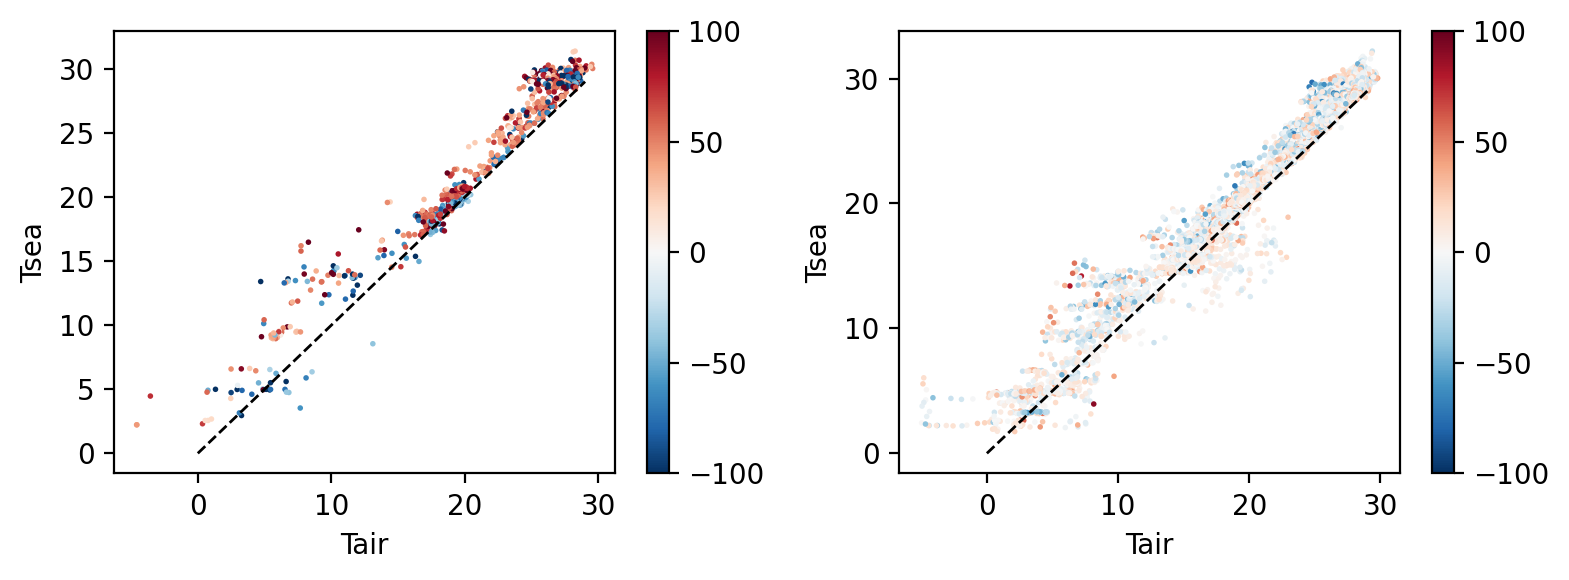

In [85]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)

ds_psd_sub = ds_psd.where(abs(ds_psd.hlb - ds_psd.hlc) > 50, drop=True)
axes[0].plot(np.arange(0,30), np.arange(0,30), '--', c='k', lw=1)
img1 = axes[0].scatter(ds_psd_sub.tair, ds_psd_sub.tsea, 
                s=4, c=-ds_psd_sub.LH+ds_psd_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair')
axes[0].set_ylabel('Tsea')

ds_psd_sub = ds_psd.where(abs(ds_psd.hlb - ds_psd.hlc) < 50, drop=True)
axes[1].plot(np.arange(0,30), np.arange(0,30), '--', c='k', lw=1)
img2 = axes[1].scatter(ds_psd_sub.tair, ds_psd_sub.tsea, 
                s=4, c=-ds_psd_sub.LH+ds_psd_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair')
axes[1].set_ylabel('Tsea')
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

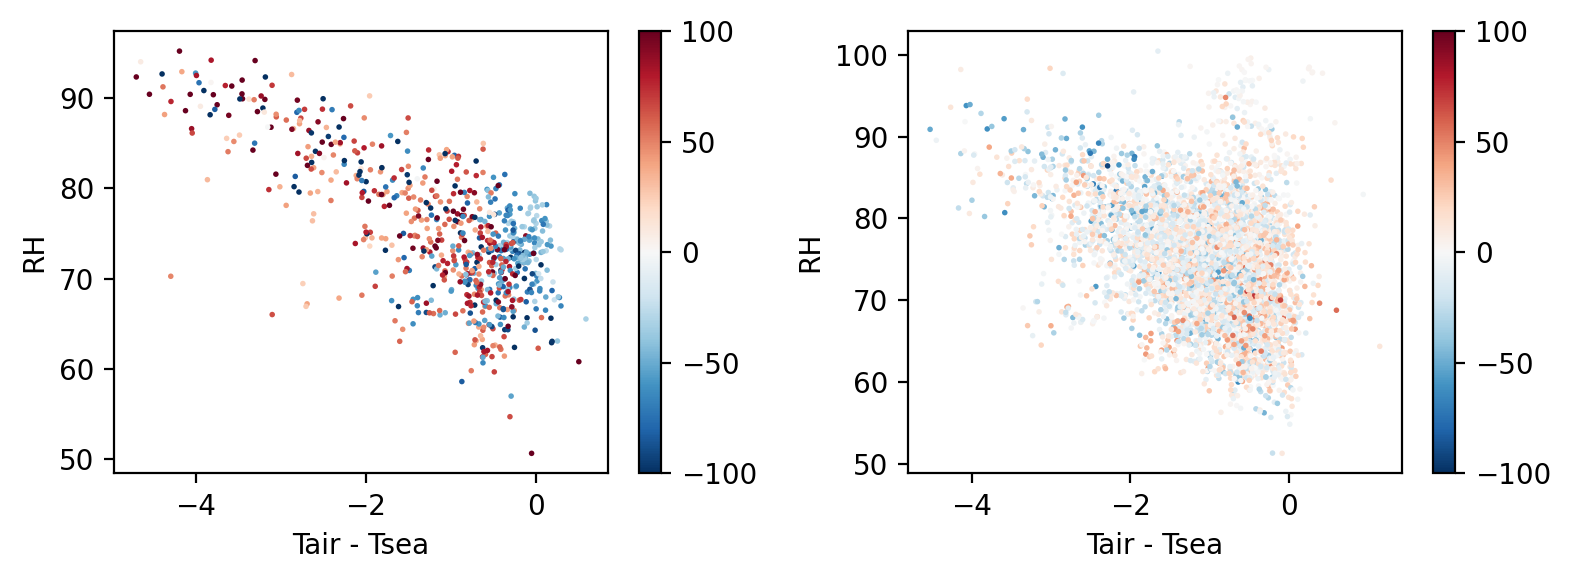

In [88]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)

ds_ = ds_sets[3]
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)

img1 = axes[0].scatter(ds_sub.tair - ds_sub.tsea, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair - Tsea')
axes[0].set_ylabel('RH')

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.tair - ds_sub.tsea, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair - Tsea')
axes[1].set_ylabel('RH') 
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

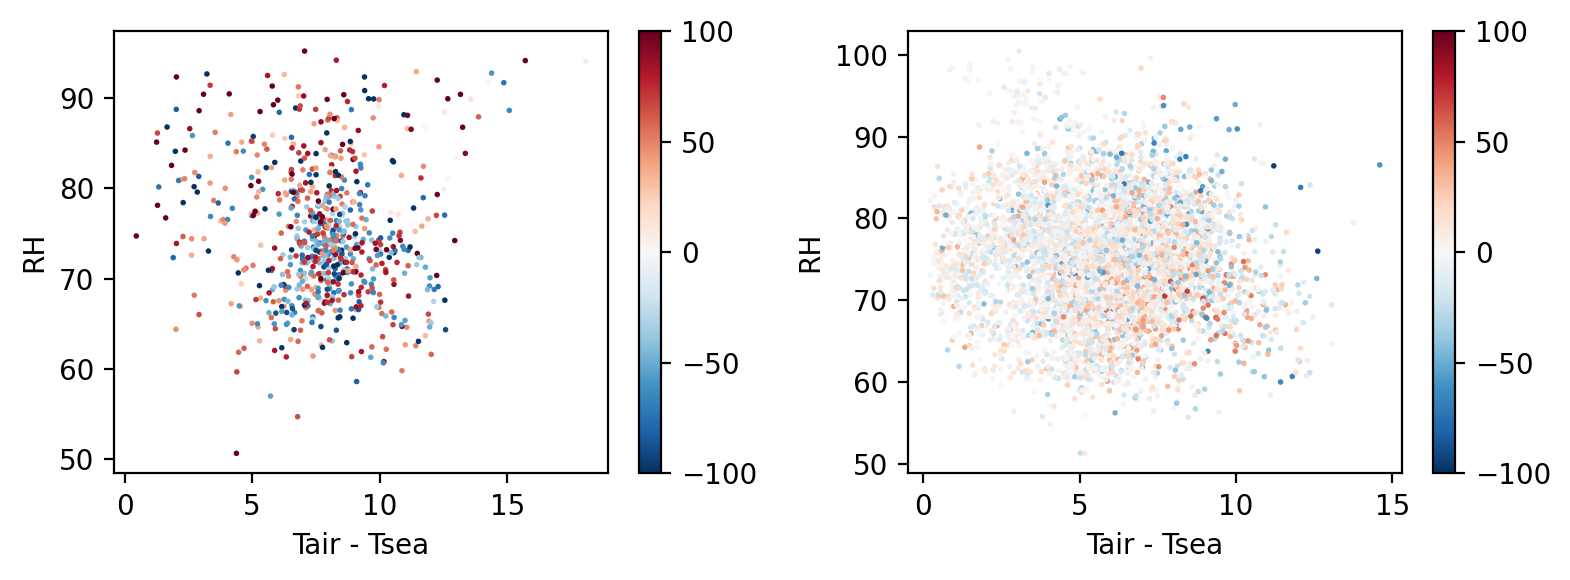

In [90]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)

ds_ = ds_sets[3]
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)

img1 = axes[0].scatter(ds_sub.U, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('Tair - Tsea')
axes[0].set_ylabel('RH')

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.U, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('Tair - Tsea')
axes[1].set_ylabel('RH') 
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

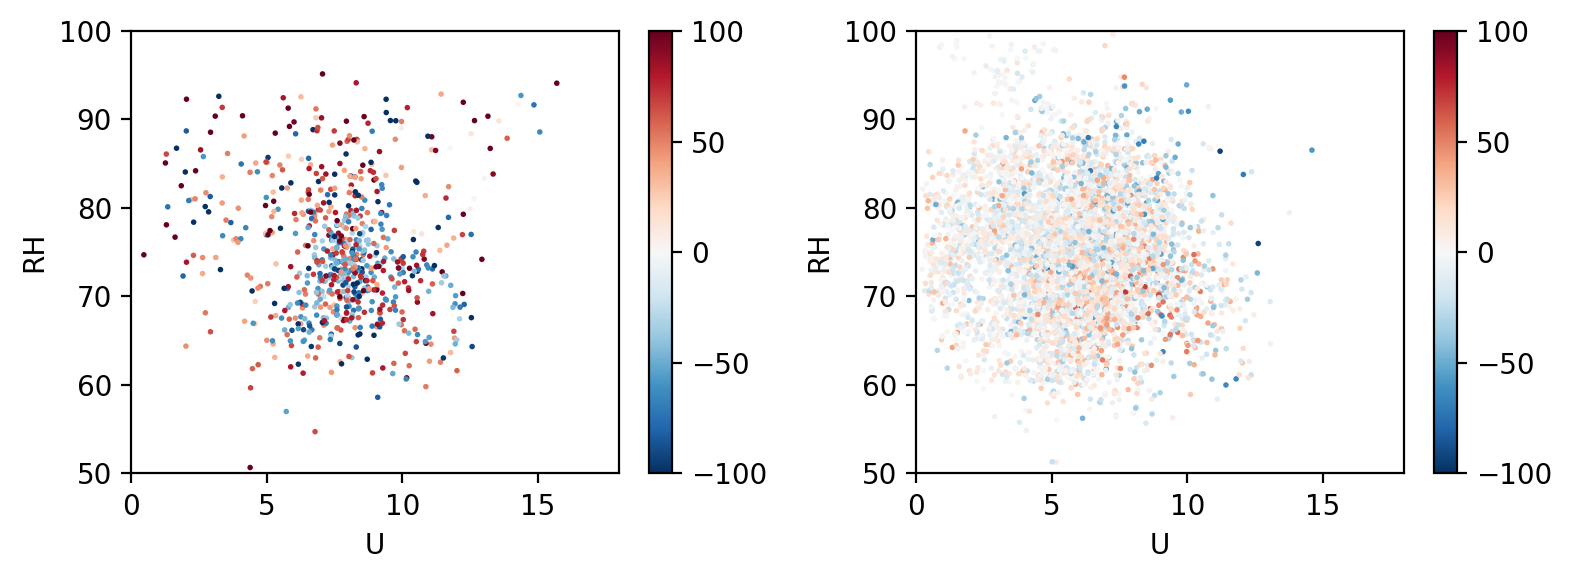

In [99]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=200)

ds_ = ds_sets[3]
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)

img1 = axes[0].scatter(ds_sub.U, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[0].set_xlabel('U')
axes[0].set_ylabel('RH')

ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) < 50, drop=True)
img2 = axes[1].scatter(ds_sub.U, ds_sub.rh,
                s=4, c=-ds_sub.LH+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', 
                vmax=100, vmin=-100)
axes[1].set_xlabel('U')
axes[1].set_ylabel('RH') 
axes[0].set_xlim([0,18]); axes[1].set_xlim([0,18])
axes[0].set_ylim([50,100]); axes[1].set_ylim([50,100])
plt.colorbar(img1)
plt.colorbar(img2)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
ds_sub = ds_.where(abs(ds_.hlb - ds_.hlc) > 50, drop=True)
axes[0].plot(np.arange(-2,3), np.arange(-2,3), '--', c='k', lw=1)
axes[0].scatter((ds_sub.tair - tair_mean)/tair_std, (ds_sub.tsea-tsea_mean)/tsea_std, 
                s=2, c=-ds_sub.hlb+ds_sub.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=100, vmin=-100)
axes[1].plot(np.arange(-2,3), np.arange(-2,3), '--', c='k', lw=1)
axes[1].scatter((ds_.tair - tair_mean)/tair_std, (ds_.tsea-tsea_mean)/tsea_std, 
                s=2, c=-ds_.hlb+ds_.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=100, vmin=-100)
plt.tight_layout()

In [29]:
ds_ = ds_sets[1]
ds_ = ds_.where(abs(ds_.qsea - ds_.qair) > 0.001, drop=True)
# ds_sub1 = ds_.where(abs(ds_.ann_CE - ds_.CE) < abs(ds_.bulk_CE - ds_.CE), drop=True)
# ds_sub2 = ds_.where(abs(ds_.ann_CE - ds_.CE) > abs(ds_.bulk_CE - ds_.CE), drop=True)
ds_sub1 = ds_.where(abs(ds_.LH - ds_.hlc) < abs(ds_.hlb - ds_.hlc), drop=True)
ds_sub2 = ds_.where(abs(ds_.LH - ds_.hlc) > abs(ds_.hlb - ds_.hlc), drop=True)


print(ds_sub1.sizes)
print(ds_sub2.sizes)

p_mean = ds_.p.mean()
p_std = ds_.p.std()
rh_mean = ds_.rh.mean()
rh_std = ds_.rh.std()
tair_mean = ds_.tair.mean()
tair_std = ds_.tair.std()
tsea_mean = ds_.tsea.mean()
tsea_std = ds_.tsea.std()
U_mean = ds_.U.mean()
U_std = ds_.U.std()

dt = ds_.tair - ds_.tsea
dt_mean = dt.mean()
dt_std = dt.std()

Frozen({'time': 259})
Frozen({'time': 194})


/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


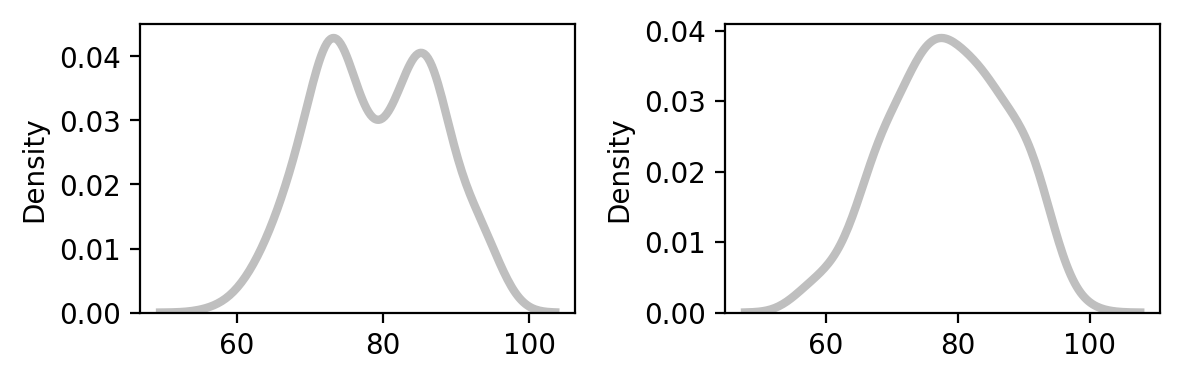

In [58]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=[6,2], dpi=200)
sns.kdeplot(ds_sub1.rh, ax=axes[0], label='Total', c='gray', lw=3, alpha=0.5)
sns.kdeplot(ds_sub2.rh, ax=axes[1], label='Total', c='gray', lw=3, alpha=0.5)
plt.tight_layout()

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=[6,2], dpi=200)
sns.kdeplot(ds_sub1.rh, ax=axes[0], label='Total', c='gray', lw=3, alpha=0.5)
sns.kdeplot(ds_sub2.rh, ax=axes[1], label='Total', c='gray', lw=3, alpha=0.5)
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

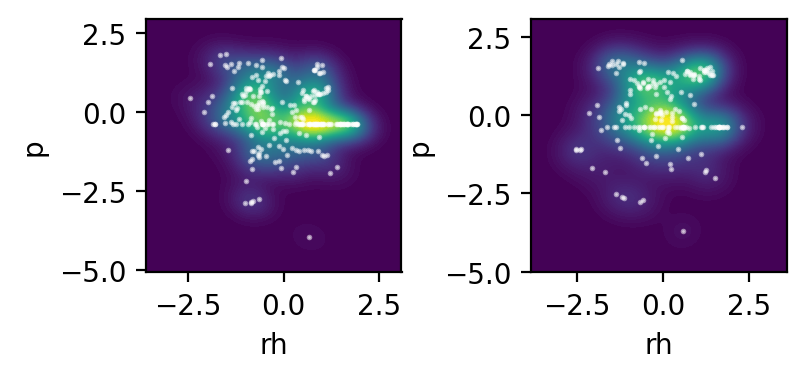

In [78]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
sns.kdeplot(x=(ds_sub1.rh - rh_mean)/rh_std, y=(ds_sub1.p-p_mean)/p_std, 
            ax=axes[0], fill=True, cmap="viridis", thresh=0, levels=100)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.p-p_mean)/p_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
sns.kdeplot(x=(ds_sub2.rh-rh_mean)/rh_std, y=(ds_sub2.p-p_mean)/p_std, 
            ax=axes[1], fill=True, cmap="viridis", thresh=0, levels=100)
axes[1].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.p-p_mean)/p_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

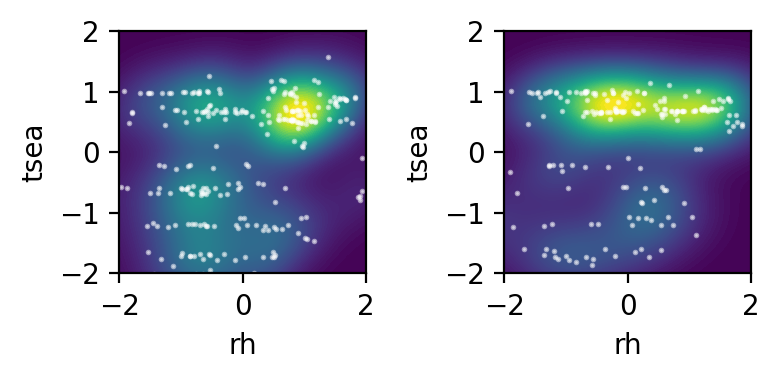

In [99]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
sns.kdeplot(x=(ds_sub1.rh - rh_mean)/rh_std, y=(ds_sub1.tsea-tsea_mean)/tsea_std, 
            ax=axes[0], fill=True, cmap="viridis", thresh=0, levels=100)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
sns.kdeplot(x=(ds_sub2.rh-rh_mean)/rh_std, y=(ds_sub2.tsea-tsea_mean)/tsea_std, 
            ax=axes[1], fill=True, cmap="viridis", thresh=0, levels=100)
axes[1].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.tsea-tsea_mean)/tsea_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
axes[0].set_xlim([-2,2]); axes[0].set_ylim([-2,2])
axes[1].set_xlim([-2,2]); axes[1].set_ylim([-2,2])
plt.tight_layout()

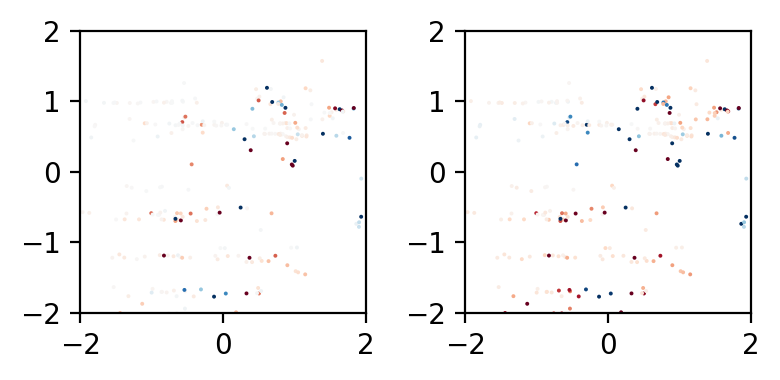

In [106]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=2, c=(ds_sub1.LH-ds_sub1.hlc)/ds_sub1.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=5, vmin=-5)
axes[1].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=2, c=(ds_sub1.hlb-ds_sub1.hlc)/ds_sub1.hlc, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=5, vmin=-5)
axes[0].set_xlim([-2,2]); axes[0].set_ylim([-2,2])
axes[1].set_xlim([-2,2]); axes[1].set_ylim([-2,2])
plt.tight_layout()

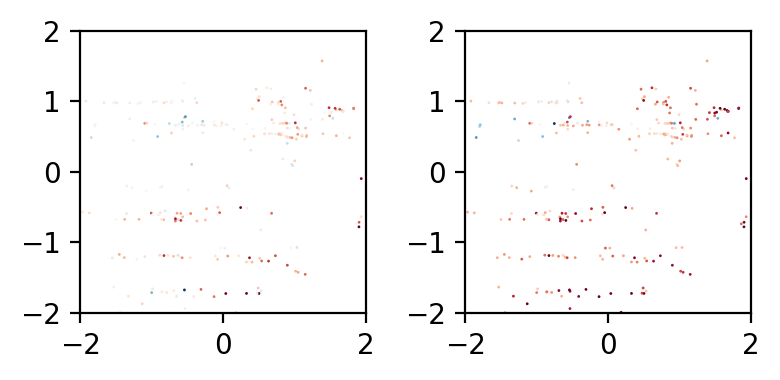

In [120]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=1, c=ds_sub1.ann_CE-ds_sub1.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
axes[1].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=1, c=ds_sub1.bulk_CE-ds_sub1.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
axes[0].set_xlim([-2,2]); axes[0].set_ylim([-2,2])
axes[1].set_xlim([-2,2]); axes[1].set_ylim([-2,2])
plt.tight_layout()

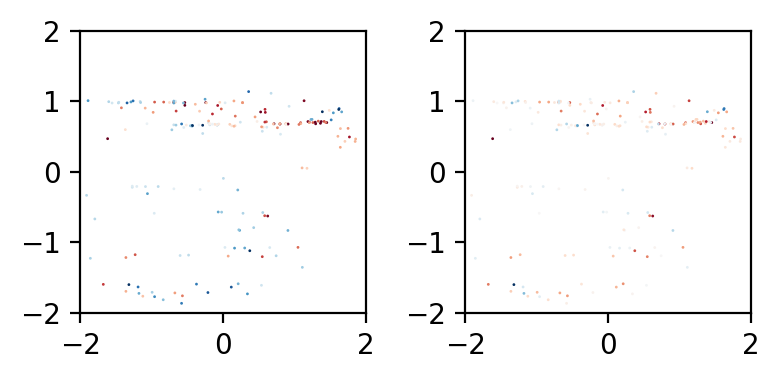

In [121]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
axes[0].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.tsea-tsea_mean)/tsea_std, 
                s=1, c=ds_sub2.ann_CE-ds_sub2.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
axes[1].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.tsea-tsea_mean)/tsea_std, 
                s=1, c=ds_sub2.bulk_CE-ds_sub2.CE, cmap="RdBu_r", alpha=1, edgecolor='none', vmax=1e-3, vmin=-1e-3)
axes[0].set_xlim([-2,2]); axes[0].set_ylim([-2,2])
axes[1].set_xlim([-2,2]); axes[1].set_ylim([-2,2])
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

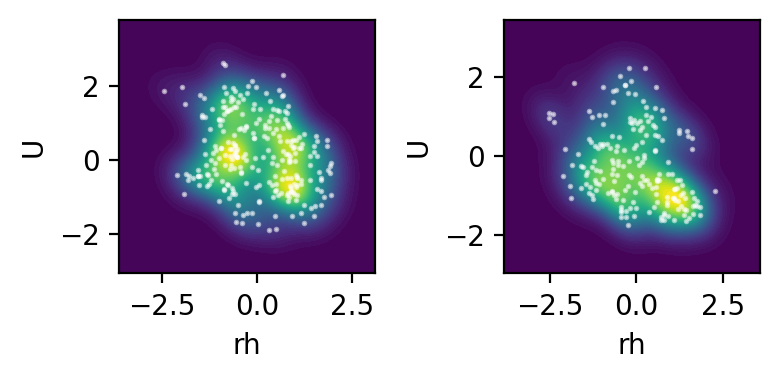

In [81]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
sns.kdeplot(x=(ds_sub1.rh - rh_mean)/rh_std, y=(ds_sub1.U-U_mean)/U_std, 
            ax=axes[0], fill=True, cmap="viridis", thresh=0, levels=100)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.U-U_mean)/U_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
sns.kdeplot(x=(ds_sub2.rh-rh_mean)/rh_std, y=(ds_sub2.U-U_mean)/U_std, 
            ax=axes[1], fill=True, cmap="viridis", thresh=0, levels=100)
axes[1].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.U-U_mean)/U_std, 
                s=1, color="white", alpha=0.5, edgecolor='white')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[4,2], dpi=200)
sns.kdeplot(x=(ds_sub1.rh - rh_mean)/rh_std, y=(ds_sub1.tsea-tsea_mean)/tsea_std, 
            ax=axes[0], fill=True, cmap="viridis", thresh=0, levels=100)
axes[0].scatter((ds_sub1.rh - rh_mean)/rh_std, (ds_sub1.tsea-tsea_mean)/tsea_std, 
                s=2, color="white", alpha=0.5, edgecolor='white')
sns.kdeplot(x=(ds_sub2.rh-rh_mean)/rh_std, y=(ds_sub2.tsea-tsea_mean)/tsea_std, 
            ax=axes[1], fill=True, cmap="viridis", thresh=0, levels=100)
axes[1].scatter((ds_sub2.rh - rh_mean)/rh_std, (ds_sub2.tsea-tsea_mean)/tsea_std, 
                s=2, color="white", alpha=0.5, edgecolor='white')
plt.tight_layout()

Text(0.5, 0.5, 'Pressure')

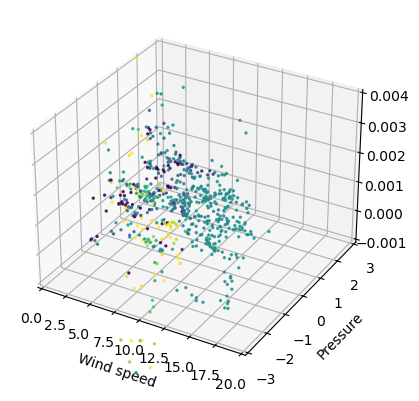

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ds_ = ds_sets[1]
# ds_ = ds_.where(abs(ds_['hlb']-ds_['hlc'])>abs(ds_['LH']-ds_['hlc']), drop=True)

ds_['p_norm'] = (ds_['p'] - ds_['p'].mean())/ds_['p'].std()
ax.scatter(ds_['U'], ds_['p_norm'], ds_['ann_CE'], c=ds_['zt']/ds_['MOL'], cmap="viridis", 
           marker='o', s=2, alpha=0.8, vmax=1, vmin=-1)

ax.set_zlim([-0.001,0.004]); ax.set_xlim([0,20]); ax.set_ylim([-3,3])

plt.xlabel('Wind speed')
plt.ylabel('Pressure')

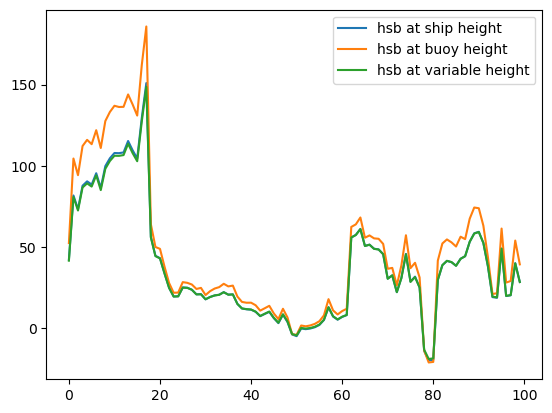

In [101]:
plt.plot(A3p5[:,2][:100], label='hsb at ship height')
plt.plot(A3p5_buoy[:,2][:100], label='hsb at buoy height')
plt.plot(-ds_psd.hsb.values[:100], label='hsb at variable height')
plt.legend()

In [ ]:
# Le checked
# qair checked
# qsea checked now
# rhoa checked 
# gf can be between 1.01 to 1.8 
# plt.plot(A3p5[:,27][:100], label='Qs')
# plt.plot(ds_psd.qsea[:100], label='Qs')
# plt.plot(A3p5[:,28][:100]/1000, label='Q air')
# plt.plot(ds_psd.qair[:100], label='Q air')

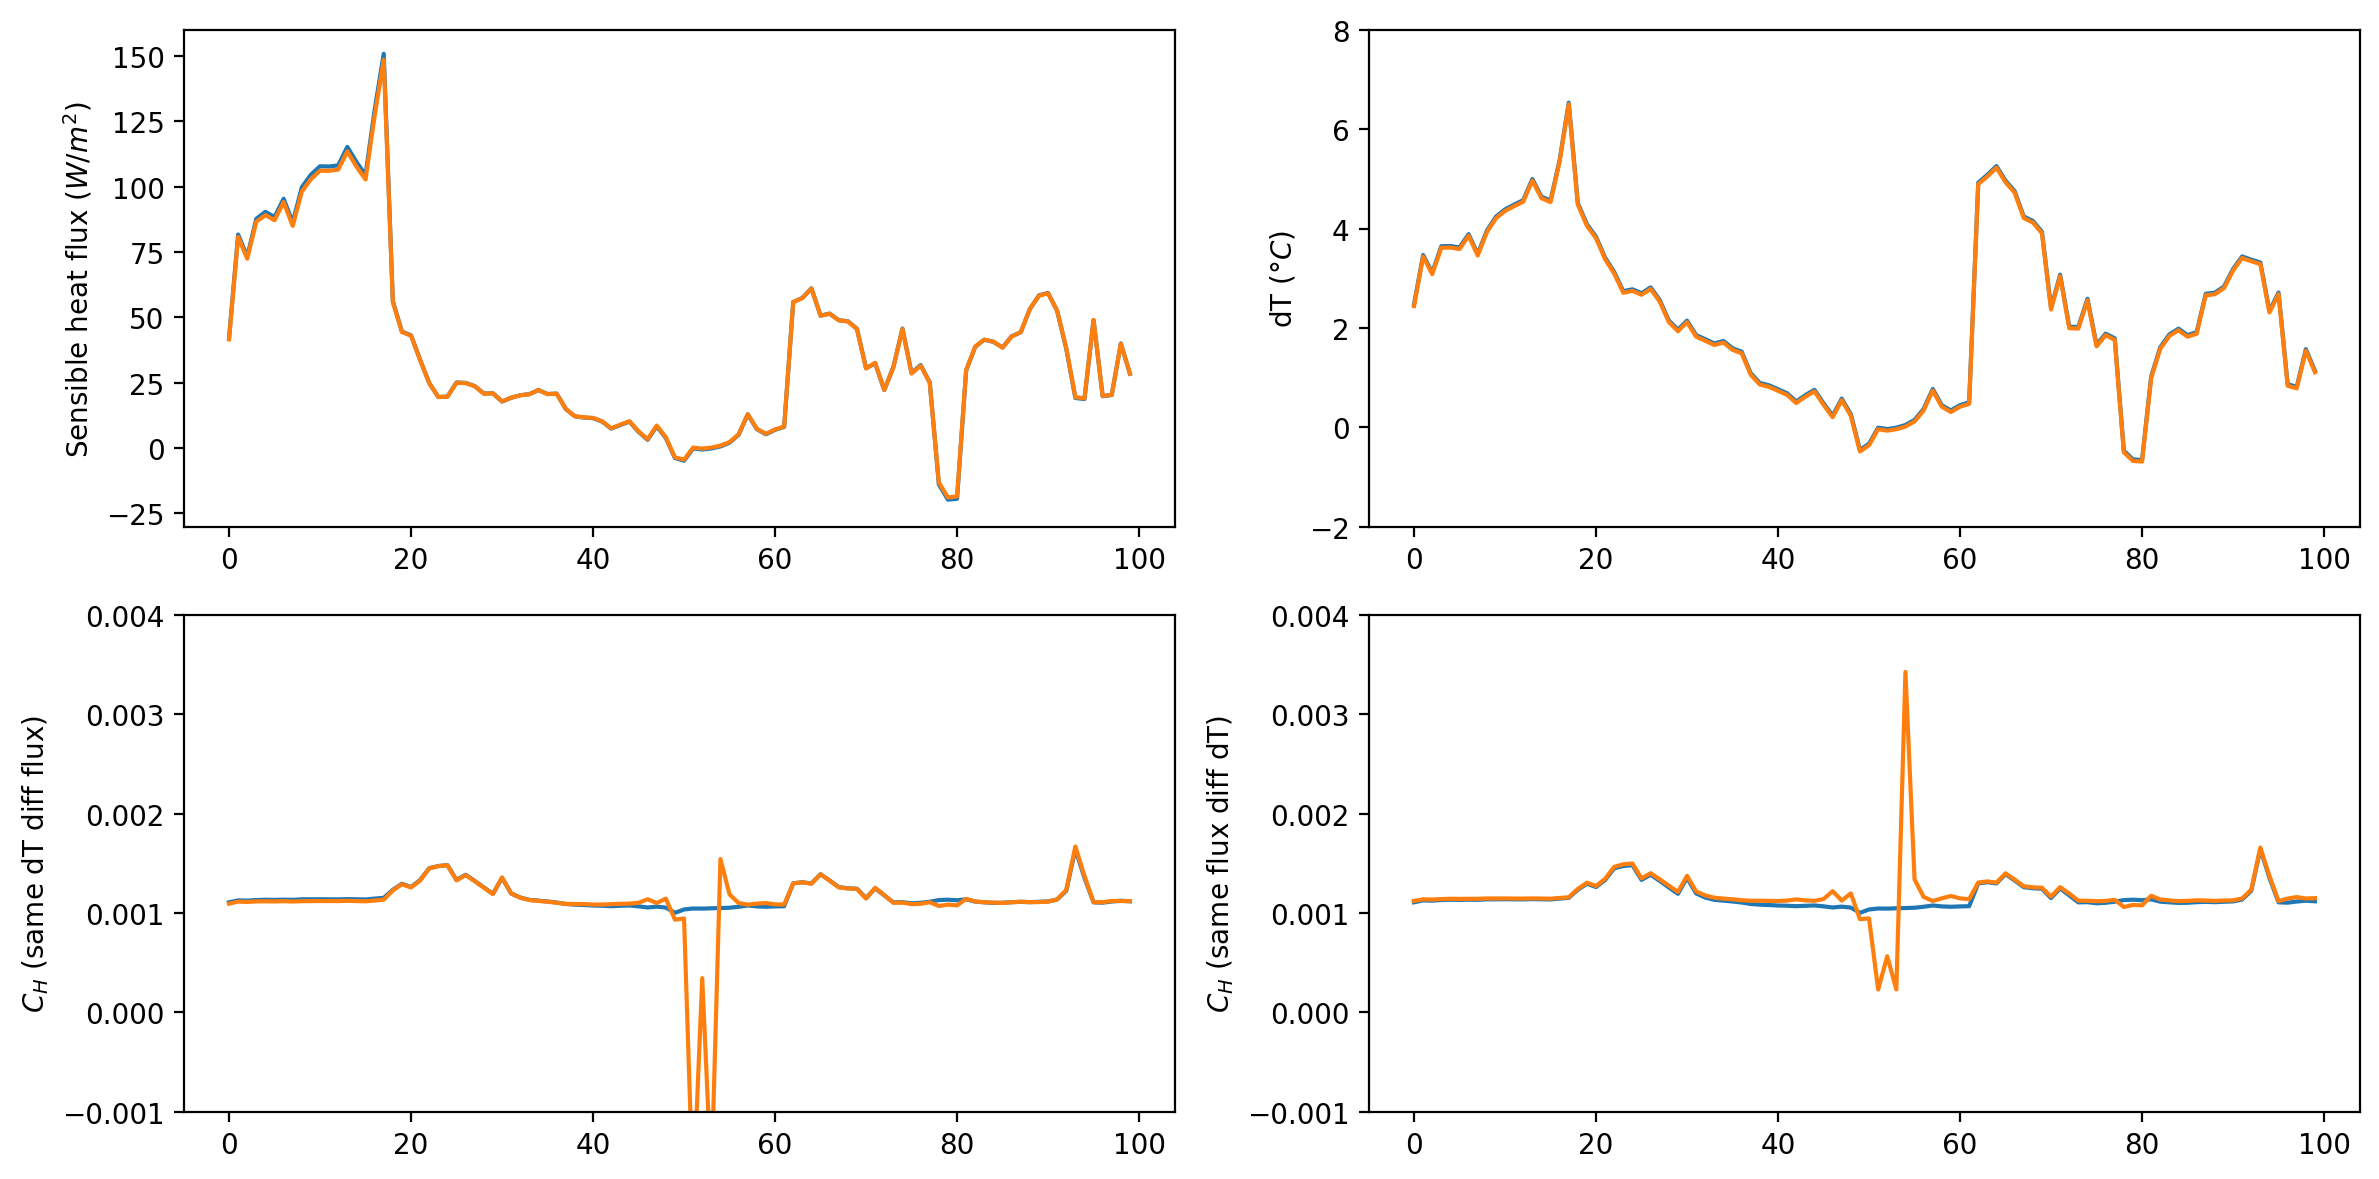

In [12]:
fig, axes = plt.subplots(2, 2, figsize=[12,6], dpi=200)

ax = axes[0,0]
ax.plot(A3p5[:,2][:100])
ax.plot(-ds_psd.hsb.values[:100])
# ax.plot(A3p6[:,2][:100])
ax.set_ylim([-30,160])
ax.set_ylabel(r'Sensible heat flux ($W/m^2$)')

ax = axes[0,1]
ax.plot(A3p5[:,32][:100])
ax.plot(ds_psd.tsea.values[:100] - ds_psd.tair.values[:100] - 0.0098*ds['zt'].values[:100])
ax.set_ylim([-2,8])
ax.set_ylabel(r'dT ($\degree C$)')

ax = axes[1,0]
ax.plot(A3p5[:,2][:100]/A3p5[:,32][:100]/ds['rhoair'].values[:100]/ds['U'].values[:100]/ds['cpa'].values[:100])
ax.plot(-ds_psd.hsb.values[:100]/A3p5[:,32][:100]/ds['rhoair'].values[:100]/ds['U'].values[:100]/ds['cpa'].values[:100])
ax.set_ylim([-0.001,0.004])
ax.set_ylabel(r'$C_H$ (same dT diff flux)')

ax = axes[1,1]
ax.plot(A3p5[:,2][:100]/A3p5[:,32][:100]/ds['rhoair'].values[:100]/ds['U'].values[:100]/ds['cpa'].values[:100])
ax.plot(A3p5[:,2][:100]/(ds_psd.tsea.values[:100] - ds_psd.tair.values[:100] - 0.0098*ds['zt'].values[:100])/ds['rhoair'].values[:100]/ds['U'].values[:100]/ds['cpa'].values[:100])
ax.set_ylim([-0.001,0.004])
ax.set_ylabel(r'$C_H$ (same flux diff dT)')

plt.tight_layout()

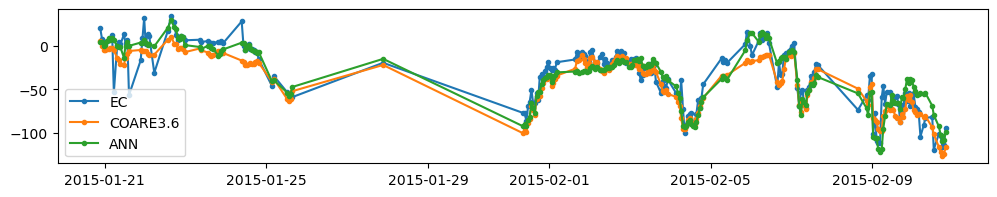

In [30]:
fig = plt.figure(figsize=[12,2])
ds1 = ds_sets[1].where(ds_sets[1].pcode==67, drop=True)
plt.plot(ds1.time, ds1.hlc, '.-', label='EC')
plt.plot(ds1.time, ds1.hlb, '.-', label='COARE3.6')
plt.plot(ds1.time, ds1.LH, '.-', label='ANN')
plt.legend()

(-100.0, 100.0)

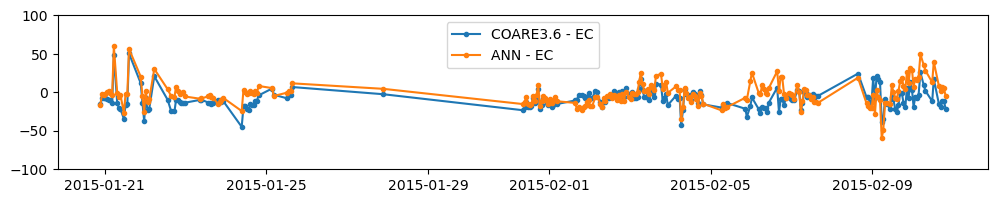

In [34]:
fig = plt.figure(figsize=[12,2])
ds1 = ds_sets[1].where(ds_sets[1].pcode==67, drop=True)
plt.plot(ds1.time, ds1.hlb-ds1.hlc, '.-', label='COARE3.6 - EC')
plt.plot(ds1.time, ds1.LH-ds1.hlc, '.-', label='ANN - EC')
plt.legend(loc='upper center')
plt.ylim([-100,100])

In [ ]:
fig = plt.figure(figsize=[12,2])
ds1 = ds_sets[1].where(ds_sets[1].pcode==78, drop=True)
plt.plot(ds1.time, ds1.hlb-ds1.hlc, '.-', label='COARE3.6 - EC')
plt.plot(ds1.time, ds1.LH-ds1.hlc, '.-', label='ANN - EC')
plt.legend(loc='upper center')
plt.ylim([-100,100])

(-200.0, 200.0)

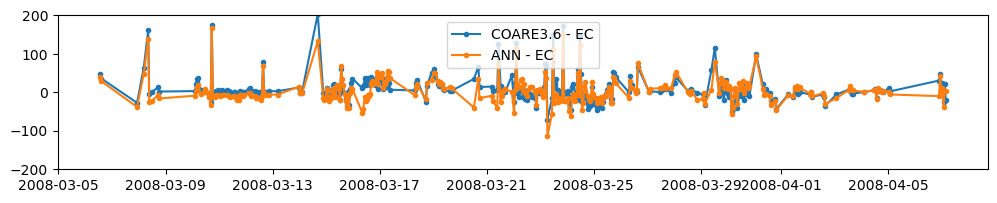

In [39]:
splits = [[77], [67, 72, 78], [73, 71], [68, 83, 69, 87]]
fig = plt.figure(figsize=[12,2])
ds1 = ds_sets[2].where(ds_sets[2].pcode==71, drop=True)
plt.plot(ds1.time, ds1.hlb-ds1.hlc, '.-', label='COARE3.6 - EC')
plt.plot(ds1.time, ds1.LH-ds1.hlc, '.-', label='ANN - EC')
plt.legend(loc='upper center')
plt.ylim([-200,200])

(-200.0, 200.0)

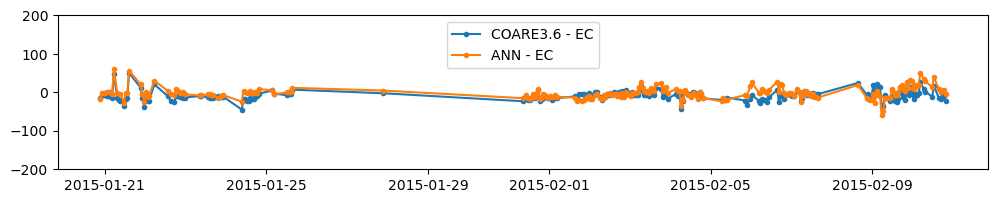

In [48]:
splits = [[77], [67, 72, 78], [73, 71], [68, 83, 69, 87]]
fig = plt.figure(figsize=[12,2])
ds1 = ds_sets[1].where(ds_sets[1].pcode==67, drop=True)
plt.plot(ds1.time, ds1.hlb-ds1.hlc, '.-', label='COARE3.6 - EC')
plt.plot(ds1.time, ds1.LH-ds1.hlc, '.-', label='ANN - EC')
plt.legend(loc='upper center')
plt.ylim([-200,200])

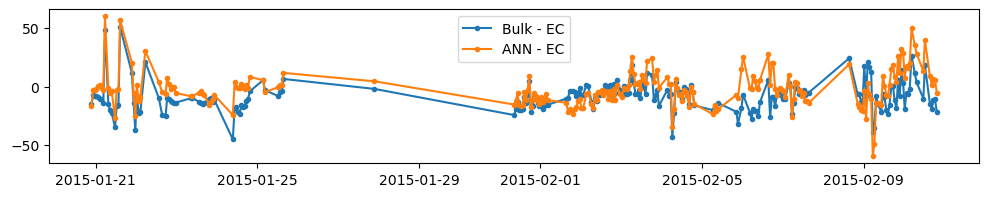

In [12]:
# [67, 72, 78]
fig = plt.figure(figsize=[12,2])
ds1 = testing_ds.where(testing_ds.pcode==67, drop=True)
plt.plot(ds1.time, ds1.hlb - ds1.hlc, '.-', label='Bulk - EC')
plt.plot(ds1.time, ds1.LH - ds1.hlc, '.-', label='ANN - EC')
plt.legend()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[10, 4])
testing_ds['ann_CD'] = testing_ds['M'] / testing_ds['U']**2 
testing_ds['bulk_CD'] = testing_ds['taubx'] / testing_ds['U']**2
img1 = axes[0].scatter(testing_ds['U'], testing_ds['ann_CD'], c=testing_ds['tair']-testing_ds['tsea'], marker='o', cmap='viridis', alpha=0.8)
img2 = axes[1].scatter(testing_ds['U'], testing_ds['bulk_CD'], c=testing_ds['tair']-testing_ds['tsea'], marker='^', cmap='viridis', alpha=0.8)
axes[0].set_ylim([0,0.004]); axes[0].set_xlim([0,20])
axes[1].set_ylim([0,0.004]); axes[1].set_xlim([0,20])
plt.colorbar(img1)
plt.colorbar(img2)

In [26]:
testing_ds['annSE'] = (testing_ds.LH - testing_ds.hlc)**2
testing_ds['bulkSE'] = (testing_ds.hlb - testing_ds.hlc)**2

testing_ds['ann_bias'] = (testing_ds.LH - testing_ds.hlc)
testing_ds['bulk_bias'] = (testing_ds.hlb - testing_ds.hlc)

U_bins = np.arange(0, 24, 4)
binned = testing_ds.annSE.groupby_bins(testing_ds.U, U_bins).mean()
print(binned.values)
binned = testing_ds.bulkSE.groupby_bins(testing_ds.U, U_bins).mean()
print(binned.values)

binned = testing_ds.ann_bias.groupby_bins(testing_ds.U, U_bins).mean()
print(binned.values)
binned = testing_ds.bulk_bias.groupby_bins(testing_ds.U, U_bins).mean()
print(binned.values)

[ 106.75078586  216.54716029  456.69931222  641.17816985 1307.7241638 ]
[  47.43769318  289.37674927  711.21921466 1478.14207892 3344.2219471 ]
[ -0.59826352  -2.15637618  -7.47543754  -9.41727179 -18.82321368]
[ -1.89322075  -3.96508026 -12.66694456 -25.18265759 -42.14258055]


In [32]:
RH_bins = np.arange(60, 110, 10)
binned = testing_ds.annSE.groupby_bins(testing_ds.rh, RH_bins).mean()
print(binned.values)
binned = testing_ds.bulkSE.groupby_bins(testing_ds.rh, RH_bins).mean()
print(binned.values)

binned = testing_ds.ann_bias.groupby_bins(testing_ds.rh, RH_bins).mean()
print(binned.values)
binned = testing_ds.bulk_bias.groupby_bins(testing_ds.rh, RH_bins).mean()
print(binned.values)

[557.60647661 452.98012661 231.9842515  256.3641299 ]
[754.76470024 987.03116335 322.07035532 358.98030214]
[-1.08236968 -5.88537377 -5.8642976  -1.34274355]
[-12.5112098  -14.67107517  -6.77911305  -5.18559195]
